<a href="https://colab.research.google.com/github/Je-vie/Colabs/blob/main/Basic_of_C%2B%2B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **install c++ cuda eigen3**

In [1]:
!wget https://developer.nvidia.com/compute/cuda/9.2/Prod/local_installers/cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64 -O cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64.deb
!dpkg -i cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64.deb
!apt-key add /var/cuda-repo-9-2-local/7fa2af80.pub
!apt-get update
!apt-get install cuda-9.2

# 安装eigen
!git clone https://gitlab.com/libeigen/eigen.git
!cd eigen && mkdir build && cd build && cmake .. && make install
!pkg-config --modversion eigen3
!sudo rm -rf /usr/include/Eigen
!sudo ln -s /usr/local/include/eigen3/Eigen /usr/include/Eigen

# 安装可编译cuda的c++ jupyter
!git config --global url."https://".insteadOf git://
!pip install git+git://github.com/andreinechaev/nvcc4jupyter.git

%load_ext nvcc_plugin

--2022-05-14 09:34:32--  https://developer.nvidia.com/compute/cuda/9.2/Prod/local_installers/cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64
Resolving developer.nvidia.com (developer.nvidia.com)... 152.199.39.144
Connecting to developer.nvidia.com (developer.nvidia.com)|152.199.39.144|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://developer.nvidia.com/compute/cuda/9.2/prod/local_installers/cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64 [following]
--2022-05-14 09:34:33--  https://developer.nvidia.com/compute/cuda/9.2/prod/local_installers/cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64
Reusing existing connection to developer.nvidia.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://developer.download.nvidia.com/compute/cuda/9.2/secure/Prod/local_installers/cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64.deb?IUzRSIZS1dv4-CkCmZxdIT6IvWwbnPFx1HM1pqXeNEaFFGu1UEhp5QGvsxqpOC7i4xu5n92YivGUHndfaqnYNmjnGfPD79GAvkPBO-falRZCs

#**0-CUDA编程**

### 一些简单例子

In [2]:
%%cu

/*
* 文件名 helloworld.cu
* 编译： nvcc -o helloworld helloworld.cu
*/
#include <iostream>
#include <stdio.h>
#include <Eigen/Core>
/*
* __global__ 用于修饰在gpu上运行且由cpu调用的函数
* 类似的，__device__ 用于修饰在gpu上运行且由gpu调用的函数,本例不涉及
*/
__global__ void k_add (int a, int b, int* c ){
    *c = a+b;
}
/*
* __host__用于修饰在cpu上运行的函数，一般缺省
*/
int main(void){
    int h_c;//h前缀表示host,指cpu的变量
    int *d_c;//d前缀表示device,指gpu的变量
    /*
    * cudaMalloc功能类似malloc
    * 第一个参数是指向地址的地址变量(&d_c)，第二个参数是分配显存的大小
    * 函数会修改&d_c指向的变量，完成对d_c的赋值
    * (void**)是为了让函数无需关心d_c的类型
    */
    cudaMalloc((void**)&d_c, sizeof(int));
    /*
    * gpu函数调用时有<<< >>>
    * 其中第一个变量表示使用几个线程块，第二个变量表示一个线程块使用几个线程
    */
    k_add<<<1,1>>>(2,7,d_c);
    /*
    * cudaMemcpy功能类似memcpy
    * 在cpu中不能解引用gpu变量，必须先将变量从显存复制到内存上才能访问
    * 最后一个参数指定复制的方向
    */
    cudaMemcpy(&h_c, d_c,sizeof(int),cudaMemcpyDeviceToHost);
    /*
    * cudaFree功能类似free
    */
    cudaFree(d_c);
    printf("%d\n",h_c);
    return 0;

}

9



In [3]:
%%cu
#include "cuda_runtime.h"
#include "device_launch_parameters.h"
#include <stdio.h>
__global__ void helloFromGPU(void)
{
    printf("Hello World from GPU!\n");
}

int main(void)
{
    // hello from cpu
    cudaError_t cudaStatus;
    printf("Hello World from CPU!\n");

    helloFromGPU << <1, 10 >> > ();
    cudaDeviceReset();//重置CUDA设备释放程序占用的资源=
    return 0;
}

Hello World from CPU!
Hello World from GPU!
Hello World from GPU!
Hello World from GPU!
Hello World from GPU!
Hello World from GPU!
Hello World from GPU!
Hello World from GPU!
Hello World from GPU!
Hello World from GPU!
Hello World from GPU!



In [4]:
%%cu
#include <iostream>
#include <stdio.h>
#include <Eigen/Core>

using namespace std;

int main() {
    Eigen::Matrix3d m=Eigen::Matrix3d::Random(3,3);
    cout<<"the matrixXd is"<<m<<endl;

    using Vector = Eigen::Matrix<float, Eigen::Dynamic, 1, Eigen::ColMajor>;
    Vector vector;
    uint64_t size = 6;

    vector.resize(size);
    for (uint64_t i = 0; i < size; ++i)
        vector[i] = i;

    uint64_t sizeInBytes = size * sizeof (float) + sizeof (vector);

    Vector *vectorCuda;
    cudaMalloc((void**)&vectorCuda, sizeInBytes);
    cudaMemcpy(vectorCuda, &vector, sizeInBytes, cudaMemcpyKind::cudaMemcpyHostToDevice);

    Vector result;
    result.resize(size);
    cudaMemcpy(&result, vectorCuda, sizeInBytes, cudaMemcpyKind::cudaMemcpyDeviceToHost);

    cudaFree(vectorCuda);
    std::cout << "result: " << std::endl << result << std::endl;
    return 0;
}

the matrixXd is 0.680375   0.59688 -0.329554
-0.211234  0.823295  0.536459
 0.566198 -0.604897 -0.444451
result: 
0
1
2
3
4
5



In [5]:
%%cu
#include <iostream>
#include <vector>
#include <Eigen/Core>
#include<time.h>

// cpu 版本
float dot(const std::vector<Eigen::Vector3d> &v1, const std::vector<Eigen::Vector3d> &v2) {
    std::cout << "CPU Version!!!" << std::endl;
    float x=0;
    for (int i=0; i<v1.size(); ++i)
    {
        x += v1[i].dot(v2[i]);
    }
    return x;
}

float testfunction() {
    std::vector<Eigen::Vector3d> v1(100000, Eigen::Vector3d{ 1.0, 1.0, 1.0 });
    std::vector<Eigen::Vector3d> v2(100000, Eigen::Vector3d{ 1.0, 1.0, 1.0 });

    float x = dot(v1,v2);

    return x;
}


int main(int argc, char ** argv)
{
    clock_t start,end;
    start=clock();
    double x = testfunction();
    end=clock();
	  std::cout<<"运行时间"<<(double)(end-start)<<std::endl;

    std::cerr << ">> Testfunction returned: " << x << std::endl;

	return 0;
}

CPU Version!!!
运行时间35411
>> Testfunction returned: 300000



In [ ]:
%%cu
#include <iostream>
#include <vector>
#include <Eigen/Core>
#include <stdio.h>
#include<time.h>

// gpu 版本

static void HandleError( cudaError_t err, const char *file, int line )
{
	// CUDA error handeling from the "CUDA by example" book
  // std::cout << "GPU HandleError!!!" << std::endl;
	if (err != cudaSuccess)
    {
		printf( "%s in %s at line %d\n", cudaGetErrorString( err ), file, line );
		exit( EXIT_FAILURE );
	}
}

#define HANDLE_ERROR( err ) (HandleError( err, __FILE__, __LINE__ ))

namespace Kernel
{
    __global__ void cu_dot(Eigen::Vector3d *v1, Eigen::Vector3d *v2, double *out, size_t N)
    {
        
        // printf("GPU Version !!!\n");
        int idx = blockIdx.x * blockDim.x + threadIdx.x;
        if(idx < N)
        {
            out[idx] = v1[idx].dot(v2[idx]); // 说明eigen 实现了Vector3d 的dot GPU算子
        }
        return;
    }

    // The wrapper for the calling of the actual kernel
    double dot(const std::vector<Eigen::Vector3d> & v1, const std::vector<Eigen::Vector3d> & v2)
    {        
        int n = v1.size();
        double *ret = new double[n];

        // Allocate device arrays
        Eigen::Vector3d *dev_v1, *dev_v2;
        HANDLE_ERROR(cudaMalloc((void **)&dev_v1, sizeof(Eigen::Vector3d)*n));
        HANDLE_ERROR(cudaMalloc((void **)&dev_v2, sizeof(Eigen::Vector3d)*n));
        double* dev_ret;
        HANDLE_ERROR(cudaMalloc((void **)&dev_ret, sizeof(double)*n));

        // Copy to device
        HANDLE_ERROR(cudaMemcpy(dev_v1, v1.data(), sizeof(Eigen::Vector3d)*n, cudaMemcpyHostToDevice));
        HANDLE_ERROR(cudaMemcpy(dev_v2, v2.data(), sizeof(Eigen::Vector3d)*n, cudaMemcpyHostToDevice));

        // Dot product, 线程块和线程数， 类似openmp 指定分块和指定线程数
        cu_dot<<<(n+1023)/1024, 1024>>>(dev_v1, dev_v2, dev_ret, n);
        
        // Copy to host
        HANDLE_ERROR(cudaMemcpy(ret, dev_ret, sizeof(double)*n, cudaMemcpyDeviceToHost));

        // Reduction of the array
        for (int i=1; i<n; ++i)
        {
            ret[0] += ret[i];
        }

        // Return
        return ret[0];
    }
}

double testfunction() {
    std::vector<Eigen::Vector3d> v1(100000, Eigen::Vector3d{ 1.0, 1.0, 1.0 });
    std::vector<Eigen::Vector3d> v2(100000, Eigen::Vector3d{ 1.0, 1.0, 1.0 });

    double x = Kernel::dot(v1,v2);

    return x;
}


int main(int argc, char ** argv)
{
    clock_t start,end;
    start=clock();
    double x = testfunction();
    end=clock();
	  std::cout<<"运行时间"<<(double)(end-start)<<std::endl;


    std::cerr << ">> Testfunction returned: " << x << std::endl;

	return 0;
}

结论： 矩阵较小的时候因为要进行cpu到gpu 之间的拷贝，所以并不划算

## GPU 基础概念

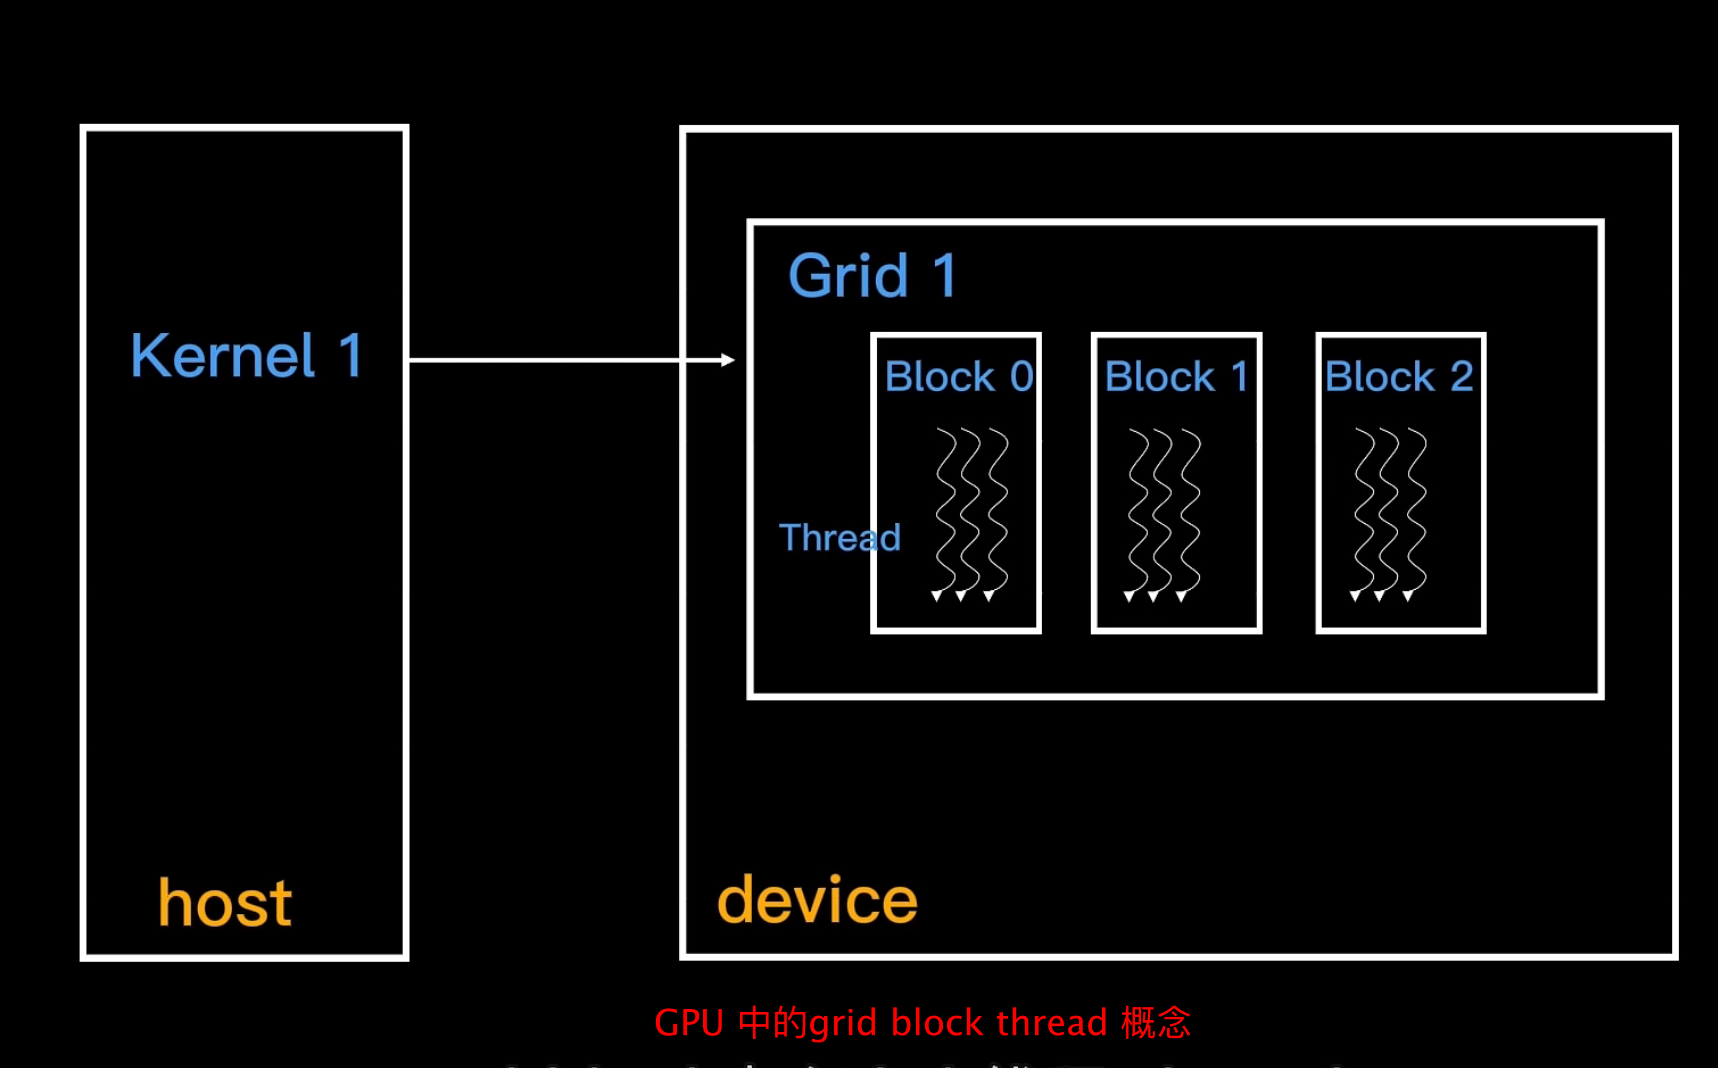

## github上的例子

In [2]:
!git clone https://github.com/Je-vie/cuda_learning.git
!ls -a

fatal: destination path 'cuda_learning' already exists and is not an empty directory.
.	 cuda_learning					    sample_data
..	 cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64.deb  src
.config  eigen


In [8]:
from google.colab import drive
# drive.mount('/gdrive')
%cd /content
%cd cuda_learning/
!python generate.py test


/content
/content/cuda_learning
Traceback (most recent call last):
  File "generate.py", line 8, in <module>
    os.mkdir(project)
FileExistsError: [Errno 17] File exists: 'test'
build/  CMakeLists.txt


# **0-SIMD编程**

    simd 中的内存对齐问题，avx要求输入向量的首地址要能被32整除，sse是被16整除。否则会因为内存不对齐程序崩溃。为了强制让编译器对齐，g++编译器可以使用__attribute__指定。

In [ ]:
%%writefile avx.cpp
#include <iostream>

#ifdef __AVX__
  #include <immintrin.h>
#else
  #warning No AVX support - will not compile
#endif

int main() {

  double input1[4] = {1, 1, 1, 1};
  double input2[4] = {1, 2, 3, 4};
  double result[4];

  std::cout << "address of input1: " << input1 << std::endl;
  std::cout << "address of input2: " << input2 << std::endl;

  __m256d a = _mm256_load_pd(input1);
  __m256d b = _mm256_load_pd(input2);
  __m256d c = _mm256_add_pd(a, b);

  _mm256_store_pd(result, c);

  std::cout << result[0] << " " << result[1] << " " << result[2] << " " << result[3] << std::endl;

  return 0;
}

Overwriting avx.cpp


In [ ]:
!g++ -o avx --std=c++11 -mavx avx.cpp
!ls
!chmod +x avx && ./avx

avx	 cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64.deb  main	 src
avx.cpp  eigen						    sample_data
address of input1: 0x7ffc610d5790
address of input2: 0x7ffc610d57b0


In [ ]:
%%writefile avx_2.cpp
#include <iostream>

#ifdef __AVX__
  #include <immintrin.h>
#else
  #warning No AVX support - will not compile
#endif

int main() {

  __attribute__ ((aligned (32))) double input1[4] = {1, 1, 1, 1};
  __attribute__ ((aligned (32))) double input2[4] = {1, 2, 3, 4};
  __attribute__ ((aligned (32))) double result[4];

  std::cout << "address of input1: " << input1 << std::endl;
  std::cout << "address of input2: " << input2 << std::endl;

  __m256d a = _mm256_load_pd(input1);
  __m256d b = _mm256_load_pd(input2);
  __m256d c = _mm256_add_pd(a, b);

  _mm256_store_pd(result, c);

  std::cout << result[0] << " " << result[1] << " " << result[2] << " " << result[3] << std::endl;

  return 0;
}

In [ ]:
!g++ -o avx_2 --std=c++11 -mavx avx_2.cpp
!ls
!chmod +x avx_2 && ./avx_2